In [221]:
# Import necessary libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import least_squares
from tqdm import tqdm
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [222]:
path = Path.cwd() / 'ece661_pics' / 'hw11_image' / 'Task1'
np.set_printoptions(precision=5)

In [223]:
class Image():
    ''' 
        Class for storing images.
    '''
    
    def __init__(self, path):
        self.path = path   

    def load(self):
        filename = f'{self.path.parent}/{self.path.name}'
        self.image = cv.imread(filename)
        name = self.path.name
        self.label = int(re.findall(r'(\d{2})', name)[0])

    def show(self):
        plt.imshow(cv.cvtColor(self.image, cv.COLOR_BGR2RGB))
    

In [224]:
# Load training set
train_set = []
for x in tqdm((path / 'train').iterdir()):
    image = Image(x)
    # Skip Window's system file 
    if image.path.suffix == '.db':
        continue
    image.load()
    train_set.append(image)

631it [00:06, 104.02it/s]


In [225]:
# Load testing set
test_set = []
for x in tqdm((path / 'test').iterdir()):
    image = Image(x)
    # Skip Window's system file
    if image.path.suffix == '.db':
        continue
    image.load()
    test_set.append(image)

631it [00:08, 76.12it/s]


In [226]:
# Compose feature vector array for PCA
train_array = []
train_label = []
for x in train_set:
    image = x.image
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    vector = image_gray.reshape(-1, 1)
    # Normalize
    vector = vector / np.linalg.norm(vector)
    train_array.append(vector)
    train_label.append(x.label)
    
train_array = np.array(train_array)
# Keep only 2d 16384 x 630
train_array = train_array[:, :, 0].T
train_label = np.array(train_label)
train_array -= np.mean(train_array, axis=1).reshape(-1, 1)

In [227]:
v, u = np.linalg.eig(np.dot(train_array.T, train_array))
# Sort the eigen vector
indices = np.argsort(v * -1)
v = v[indices]
u = u[:, indices]
# Feature array
w = np.dot(train_array, u)
w = w / np.linalg.norm(w, axis=0)

In [228]:
# Compose test vector array
test_array = []
test_label = []
for x in test_set:
    image = x.image
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    vector = image_gray.reshape(-1, 1)
    # Normalize
    vector = vector / np.linalg.norm(vector)
    test_array.append(vector)
    test_label.append(x.label)
    
test_array = np.array(test_array)
# Keep only 2d 16384 x 630
test_array = test_array[:, :, 0].T
test_label = np.array(test_label)
test_array -= np.mean(test_array, axis=1).reshape(-1, 1)

In [229]:
pca_accuracies = []
for p in range(20):
    # Use highest p feature
    wp = w[:, :p+1].T
    train_feature = np.dot(wp, train_array)
    test_feature = np.dot(wp, test_array)
    classifier = KNeighborsClassifier(n_neighbors=1)
    classifier.fit(train_feature.T, train_label)
    prediction = classifier.predict(test_feature.T)
    pca_accuracies.append(accuracy_score(test_label, prediction))

In [230]:
# Compose feature vector array for LDA
train_array = []
train_label = []
for x in train_set:
    image = x.image
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    vector = image_gray.reshape(-1, 1)
    # Normalize
    vector = vector / np.linalg.norm(vector)
    train_array.append(vector)
    train_label.append(x.label)
    
train_array = np.array(train_array)
# Keep only 2d 16384 x 630
train_array = train_array[:, :, 0].T
train_label = np.array(train_label)
# Compute global mean
global_mean = np.mean(train_array, axis=1).reshape(-1, 1)

In [231]:
# Compute class mean
class_means = []
n_class = train_label.max()
for k in range(n_class):
    indices = np.argwhere(train_label == k+1)
    class_array = train_array[:, indices.ravel()]
    mean = np.mean(class_array, axis=1)
    class_means.append(mean)

class_means = np.array(class_means).T
# Subtract with global mean
class_means -= global_mean

In [232]:
v, u = np.linalg.eig(np.dot(class_means.T, class_means))
# Sort the eigen vector
indices = np.argsort(v * -1)
v = v[indices]
u = u[:, indices]
V = np.dot(class_means, u)
# Normalized 
V = V / np.linalg.norm(V, axis=0)

In [ ]:
# Compute DB and Z
DB = np.diag(v)
Z = np.dot(V, np.linalg.inv(np.sqrt(DB)))

In [ ]:
# Compute in-class 
for i, label in enumerate(train_label):
    train_array[:, i] -= class_means[:, label-1]

In [193]:
ZTX = np.dot(Z.T, train_array)
v, u = np.linalg.eig(np.dot(ZTX, ZTX.T))
# Sort the eigen vector
indices = np.argsort(v)
v = v[indices]
u = u[:, indices]

In [194]:
# Compose training array
train_array = []
train_label = []
for x in train_set:
    image = x.image
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    vector = image_gray.reshape(-1, 1)
    # Normalize
    vector = vector / np.linalg.norm(vector)
    train_array.append(vector)
    train_label.append(x.label)
    
train_array = np.array(train_array)
# Keep only 2d 16384 x 630
train_array = train_array[:, :, 0].T
train_label = np.array(train_label)
train_array -= np.mean(train_array, axis=1).reshape(-1, 1)

In [195]:
# Compose test vector array
test_array = []
test_label = []
for x in test_set:
    image = x.image
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    vector = image_gray.reshape(-1, 1)
    # Normalize
    vector = vector / np.linalg.norm(vector)
    test_array.append(vector)
    test_label.append(x.label)
    
test_array = np.array(test_array)
# Keep only 2d 16384 x 630
test_array = test_array[:, :, 0].T
test_label = np.array(test_label)
test_array -= np.mean(test_array, axis=1).reshape(-1, 1)

In [196]:
lda_accuracies = []
for p in range(20):
    wp = np.dot(Z, u[:, :p+1]).T
    train_feature = np.dot(wp, train_array)
    test_feature = np.dot(wp, test_array)
    classifier = KNeighborsClassifier(n_neighbors=1)
    classifier.fit(train_feature.T, train_label)
    prediction = classifier.predict(test_feature.T)
    lda_accuracies.append(accuracy_score(test_label, prediction))

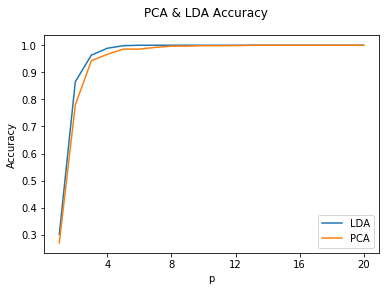

In [205]:
fig, ax = plt.subplots()
fig.suptitle('PCA & LDA Accuracy')
plt.xticks([4, 8, 12, 16, 20])
plt.xlabel('p')
plt.ylabel('Accuracy')
ax.plot(np.arange(1, 21), lda_accuracies, label='LDA')
ax.plot(np.arange(1, 21), pca_accuracies, label='PCA')
plt.legend(loc='best');
filename = path / 'chart.png'
plt.savefig(filename)